In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
import scipy as sp

In [2]:
dataset = '40_slide_tag_mouse_embryo'

In [3]:
adata = sc.read_10x_mtx(f'../../data/reference_data/{dataset}')
adata

AnnData object with n_obs × n_vars = 9037 × 32285
    var: 'gene_ids', 'feature_types'

In [4]:
adata.obs_names

Index(['AAACCCAAGACAGCTG-1', 'AAACCCAAGGGTTAGC-1', 'AAACCCACACACGGAA-1',
       'AAACCCACACATTCGA-1', 'AAACCCACAGCTAACT-1', 'AAACCCACAGGTTCCG-1',
       'AAACCCATCCGTTGAA-1', 'AAACCCATCTAATTCC-1', 'AAACGAAAGAATTCAG-1',
       'AAACGAAAGCTATCTG-1',
       ...
       'TTTGTTGAGACGGAAA-1', 'TTTGTTGAGCGTGTCC-1', 'TTTGTTGCAAGGTTGG-1',
       'TTTGTTGCAGAGATGC-1', 'TTTGTTGCATTCATCT-1', 'TTTGTTGGTGCGGCTT-1',
       'TTTGTTGGTGTTACTG-1', 'TTTGTTGTCCGTGCGA-1', 'TTTGTTGTCTCTAAGG-1',
       'TTTGTTGTCTCTGAGA-1'],
      dtype='object', length=9037)

In [5]:
df = pd.read_csv(f'../../data/reference_data/{dataset}/mouseembryo_spatial.csv', skiprows=1)
df = df.set_index('TYPE')
df.columns = ['spatial1', 'spatial2', 'cell_type']

In [6]:
df.head()

,spatial1,spatial2,cell_type
TYPE,,,
CATTCATTCCTCTAGC-1,564.960648,-3884.006494,Radial glia
TGATTCTGTCCGGATC-1,1416.580537,-1942.807161,Neuron_7
ACTGTCCCAACTCATG-1,253.794982,-2770.402645,Endothelial
GCCAGTGGTTGCATGT-1,813.296941,-3879.013115,Neuron_6
GACCCAGTCCTTCGAC-1,1431.996497,-2412.980542,Neuron_7


In [7]:
sel_cells = list(set(df.index) & set(adata.obs_names))

In [8]:
df = df.loc[sel_cells, ]
adata = adata[sel_cells, ]

In [9]:
adata.obs = df
adata.obsm['spatial'] = df[['spatial2', 'spatial1']].values

In [10]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [11]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=50)

In [12]:
adata

AnnData object with n_obs × n_vars = 4623 × 14649
    obs: 'spatial1', 'spatial2', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'spatial'

In [13]:
adata.layers['counts'] = adata.X.copy()

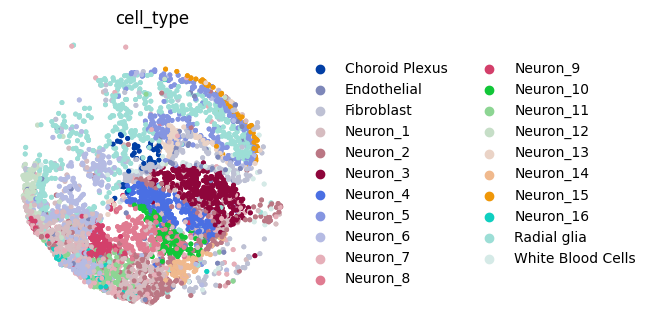

In [14]:
sq.pl.spatial_scatter(adata, color=['cell_type'], shape=None, frameon=False)

In [15]:
# remove MT genes
non_mito_genes_list = [name for name in adata.var_names if not name.startswith('MT-')]
adata = adata[:, non_mito_genes_list]

In [16]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [17]:
adata

AnnData object with n_obs × n_vars = 4623 × 14649
    obs: 'spatial1', 'spatial2', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'cell_type_colors', 'log1p'
    obsm: 'spatial'
    layers: 'counts'

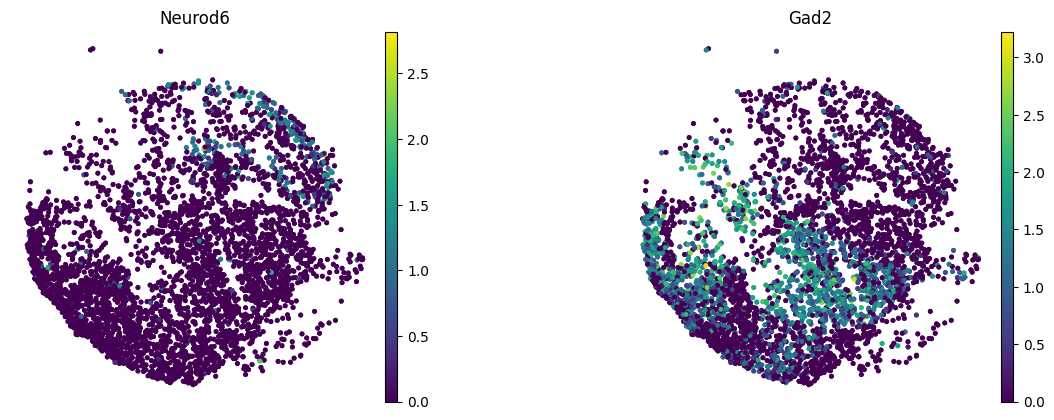

In [18]:
sq.pl.spatial_scatter(adata, color=['Neurod6', 'Gad2'], shape=None, frameon=False)

In [19]:
sq.gr.spatial_neighbors(adata, coord_type="grid", delaunay=False)
sq.gr.spatial_autocorr(adata, mode="moran", 
                       n_perms=100, n_jobs=10, 
                       genes=adata.var_names)

100%|██████████| 100/100 [00:30<00:00,  3.32/s]


In [20]:
n_svgs = 50
sel_genes = (
    adata.uns["moranI"]["I"].sort_values(ascending=False).head(n_svgs).index.tolist()
)

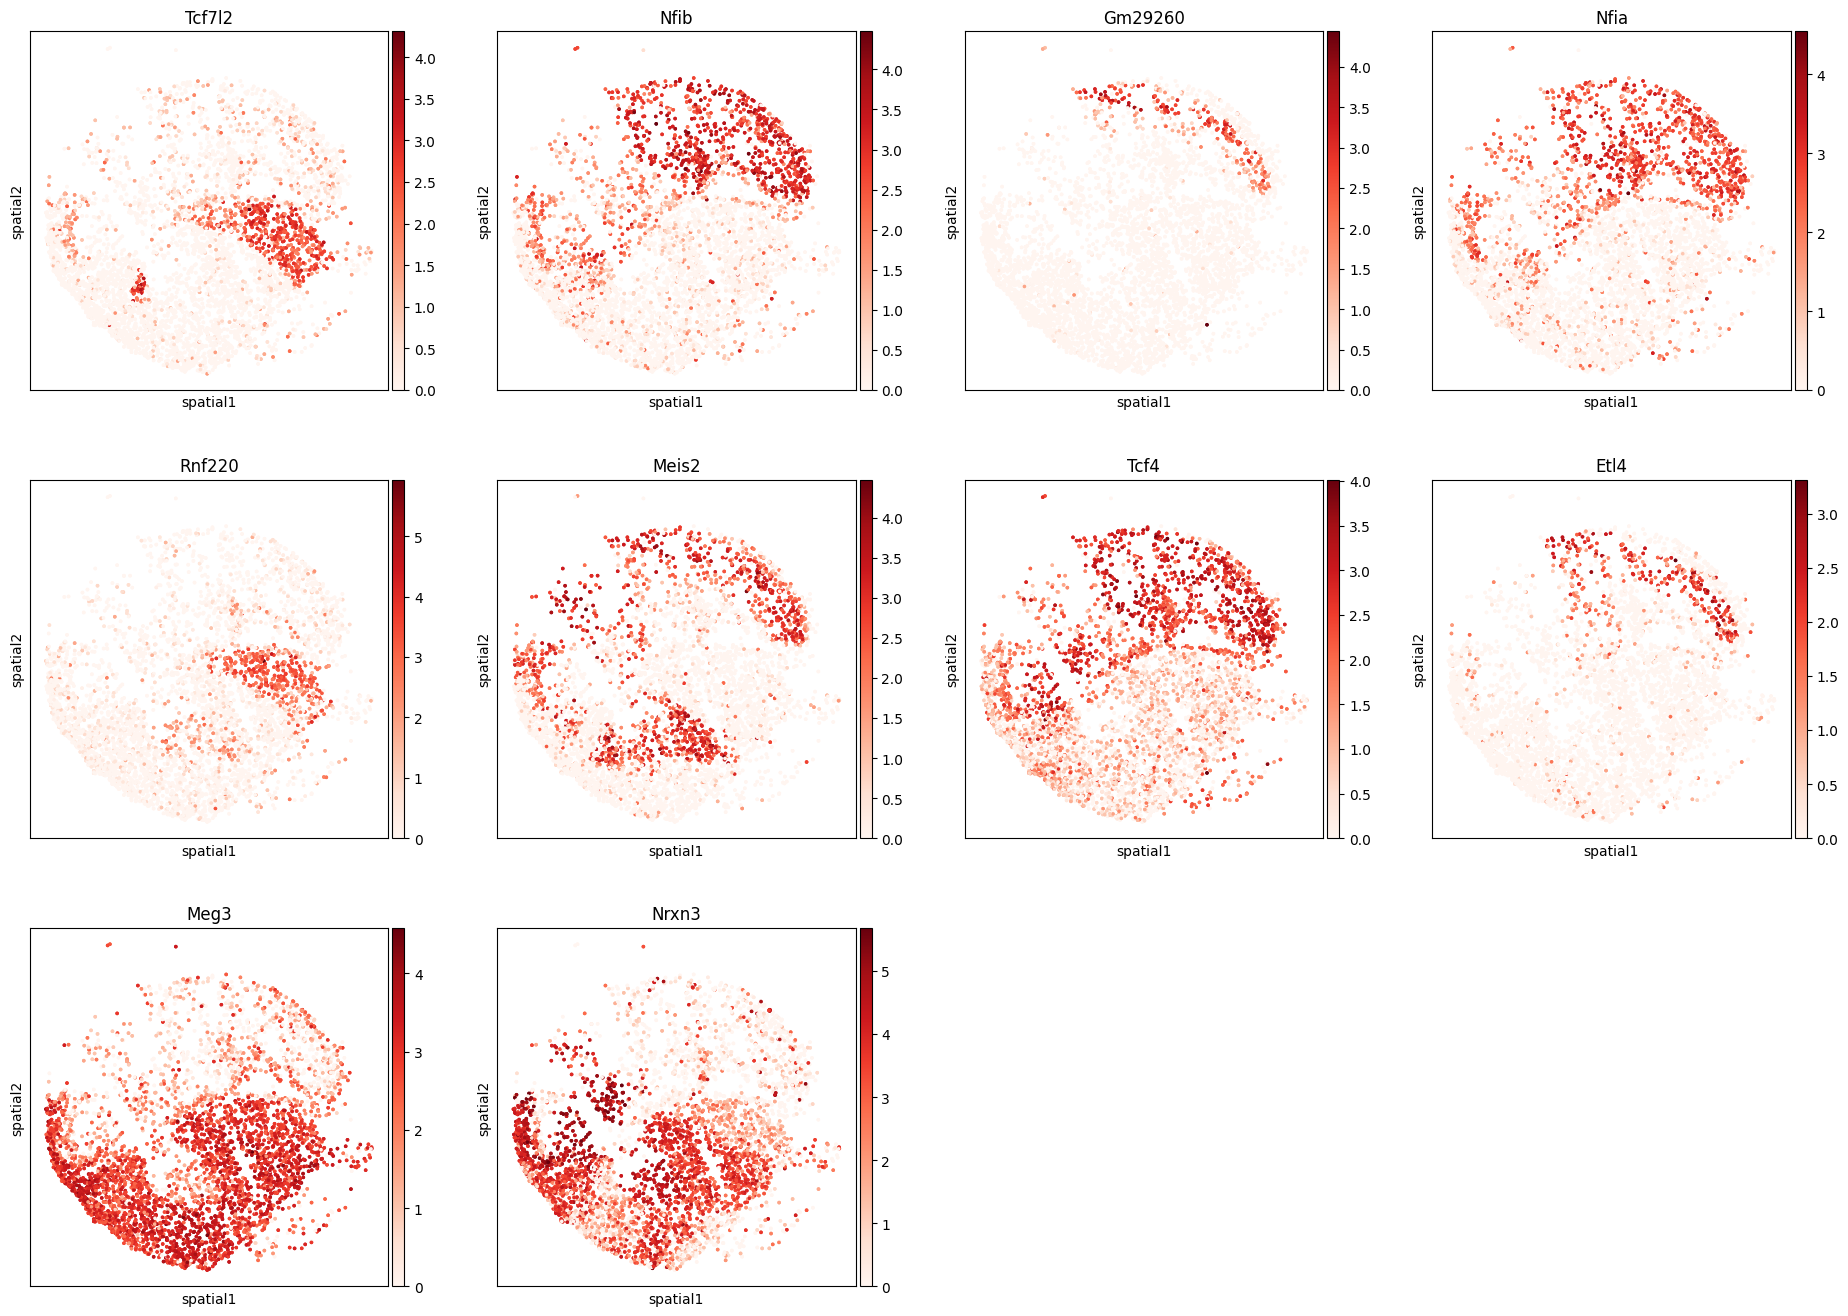

In [21]:
sq.pl.spatial_scatter(
    adata, color=sel_genes[:10], figsize=(5, 5), size=10, 
    cmap="Reds", shape=None,
)

In [22]:
# select top 50 variable genes as reference
adata = adata[:, sel_genes]

In [23]:
adata

View of AnnData object with n_obs × n_vars = 4623 × 50
    obs: 'spatial1', 'spatial2', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'cell_type_colors', 'log1p', 'spatial_neighbors', 'moranI'
    obsm: 'spatial'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [24]:
adata.write_h5ad(f'../../results/00_prepare_reference_data/{dataset}.h5ad')